# Generational changes among the religious and non-religious

Allen Downey

Copyright 2020

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

## Introduction

In this notebook I use data from the GSS to explore differences in beliefs and attitudes between Christians and Nones (people with no religious affiliation) and look at generational changes in those differences.

### Setup

If you are running this notebook in Colab, the following cell downloads the `empiricaldist` library.

If you are running in another environment, you will need to install it yourself.

In [1]:
# If we're running in Colab, install empiricaldist
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

The following cell downloads `utils.py`, which contains function I use in many data science projects.

In [2]:
# Load some utility code
import os

file = 'utils.py'
if not os.path.exists(file):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/utils.py

If everything we need is installed, the following cell should run without error.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Cdf
from utils import decorate
from utils import underride
from utils import values

### Loading the data

The following cell downloads an HDF5 file that contains the data we need.

The HDF file is created by a notebook called `01_clean.ipynb`, which you should find in the same directory as this notebook, if you want to see the details.

In [113]:
# Load the data file
import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.hdf5

Now we can read the data.

In [114]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 165)

In [115]:
values(gss['year'])

1972    1613
1973    1504
1974    1484
1975    1490
1976    1499
1977    1530
1978    1532
1980    1468
1982    1860
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2832
2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
2018    2348
Name: year, dtype: int64

For modeling purposes, I'll use data from 1998 to 2018 and respondents born during or after 1940.

These choices are a compromise between using more data, so the results are more likely to be statistically valid, and using recent data, so the models are not too influenced by irrelevant history.

I classify as "Christian" anyone who reports that their religious affiliation is Catholic, Protestant, or Christian.

In [116]:
def prepare_df(df):
    # compute quadratic and cubic terms for the models
    df['y2'] = (df['year']-2004)**2
    df['c2'] = (df['cohort']-1970)**2
    df['c3'] = (df['cohort']-1970)**3
    
    # classify religious affiliation
    df['christian'] = df['relig'].isin([1,2,11])
    df['none'] = (df['relig'] == 4)
    
    # select recent years and generations
    recent = (df['year'] >= 1998)
    notold = (df['cohort'] >= 1940)
    return df[recent & notold]

For exploration, I'll use this subset of the data without resampling, which means it oversamples some groups.

In [117]:
df = prepare_df(gss)
df.shape

(25246, 170)

For inference, I'll use 101 resamplings of the data, weighted to be representative of the adult population in the U.S.

In [118]:
from utils import resample_rows_weighted

dfs = None
dfs = [resample_rows_weighted(df, df['wtssall'])
       for i in range(101)]

## Exploring the groups

To see what the groups look like, I select Christians and Nones.

In [119]:
christian = df[df['christian']]
christian.shape

(18900, 170)

In [120]:
none = df[df['none']]
none.shape

(4774, 170)

Here's what the distribution of birth years looks like for the two groups:

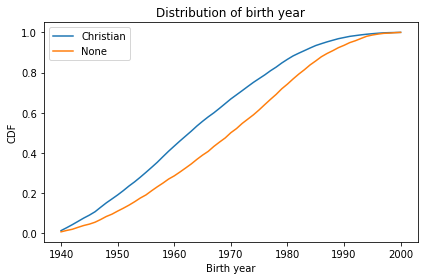

In [121]:
Cdf.from_seq(christian['cohort']).plot(label='Christian')
Cdf.from_seq(none['cohort']).plot(label='None')

decorate(xlabel='Birth year',
         ylabel='CDF',
         title='Distribution of birth year')

plt.legend();

The Christians in this dataset come from earlier cohorts, so we have to control for that.

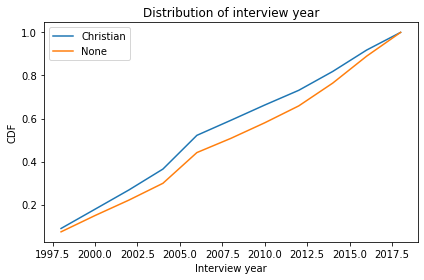

In [122]:
Cdf.from_seq(christian['year']).plot(label='Christian')
Cdf.from_seq(none['year']).plot(label='None')

decorate(xlabel='Interview year',
         ylabel='CDF',
         title='Distribution of interview year')

plt.legend();

Also, the fraction of Christians was declining over the observation period, so the Christians in the dataset were more likely to be observed earlier.  We'll have to control for that, too.

## Selecting variables

The following is a list of the variables we'll explore.

For each variable, I identify a response or list of responses to consider, and provide text that describes what that response means.

I do my best to paraphrase the wording of the question accurately, but if you have any questions, you can [consult the documentation](https://gssdataexplorer.norc.org/projects/52787/variables/data_cart).

In [249]:
variables = [
    # allow to speak
    ('spkmil', 1, 'Anti-democratic\nmilitarist'),   
    ('spkmslm', 1, 'Anti-U.S.\nMuslim clergyman'),
    ('spkath', 1, 'Opponent of churches\nand religion'),
    ('spkcom', 1, 'Communist'),
    ('spkrac', 1, 'Racist'),
    ('spkhomo', 1, 'Homosexual'),

    # allow to teach at a college or university
    ('colmil', 4, 'Anti-democratic\nmilitarist'),
    ('colmslm', 4, 'Anti-U.S.\nMuslim clergyman'),
    ('colath', 4, 'Opponent of churches\nand religion'),
    ('colcom', 5, 'Communist'),    # not fired
    ('colrac', 4, 'Racist'),
    ('colhomo', 4, 'Homosexual'),

    # do not remove from library
    ('libmil', 2, 'Anti-democratic\nmilitarist'),
    ('libmslm', 2, 'Anti-U.S.\nMuslim clergyman'),
    ('libath', 2, 'Opponent of churches\nand religion'),
    ('libcom', 2, 'Communist'),
    ('librac', 2, 'Racist'),
    ('libhomo', 2, 'Homosexual'),

    # items related to sex
    ('homosex', 1, 'Same-sex relations\nalways wrong'),
    ('premarsx', 1, 'Premarital sex\nalways wrong'),
    ('xmarsex', 1, 'Extramarital sex\nalways wrong'),
    ('teensex', 1, 'Teen sex\nalways wrong'),
    ('sexeduc', 1, 'Favor sex education\nin schools'),
    
    # items related to abortion
    ('abany', 1, 'A pregnant woman wants it\nfor any reason'),
    ('abdefect', 1, 'There is a strong chance\nof a serious defect'),
    ('abnomore', 1, 'She is married and\ndoes not want more children'),
    ('abhlth', 1, 'Her health is seriously endangered'),
    ('abpoor', 1, 'She has very low income and\ncannot afford more children'),
    ('abrape', 1, 'She became pregnant\nas a result of rape'),
    ('absingle', 1, 'She is not married and\ndoes not want to marry the man'),
    
    # other items related to public policy
    ('cappun', 2, 'Oppose death penalty\nfor murder'),
    ('gunlaw', 1, 'Favor permit to buy gun'),
    ('grass', 1, 'Marijuana should be\nmade legal'),
    ('divlaw', 1, 'Divorce should be\neasier to obtain'),
    ('prayer', 1, 'Approve SCOTUS ruling\nprohibiting school prayer'),
    ('letdie1', 1, 'Allow doctor to end life\nof terminal patient'),
    ('racopen', 2, 'Favor law barring\nhousing discrimination'),
    ('pornlaw', [2,3], 'Pornography should be legal'),
    ('affrmact', [1,2], 'Favor affirmative action\nfor blacks'),

    # items related to spending
    ('natroad', 1, 'Highways and bridges'),
    ('natsoc', 1, 'Social Security'),
    ('natmass', 1, 'Mass transportation'),
    ('natpark', 1, 'Parks and recreation'),
    ('natchld', 1, 'Assistance for child care'),
    ('natsci', 1, 'Supporting scientific research'),
    ('natenrgy', 1, 'Developing alternative\nenergy sources'),
    ('natspac', 1, 'Space exploration'),
    ('natenvir', 1, 'Improving and protecting\nthe environment'),
    ('natheal', 1, "Improving and protecting\nthe nation's health"),
    ('natcity', 1, 'Solving the problems of\nthe big cities'),
    ('natcrime', 1, 'Halting the rising\ncrime rate'),
    ('natdrug', 1, 'Dealing with drug addiction'),
    ('nateduc', 1, "Improving the nation's\neducation system"),
    ('natrace', 1, 'Improving the conditions\nof Blacks'),
    ('natarms', 1, 'The military, armaments\nand defense'),
    ('nataid', 1, 'Foreign aid'),
    ('natfare', 1, 'Welfare'),

    # confidence in institutions
    ('confinan', 1, 'Banks and financial instituions'),
    ('conbus', 1, 'Major companies'),
    ('conclerg', 1, 'Organized religion'),
    ('coneduc', 1, 'Education'),
    ('confed', 1, 'Executive branch of\nthe federal government'),
    ('conlabor', 1, 'Organized labor'),
    ('conpress', 1, 'Press'),
    ('conmedic', 1, 'Medicine'),
    ('contv', 1, 'Television'),
    ('conjudge', 1, 'U.S. Supreme Court'),
    ('consci', 1, 'Scientific community'),
    ('conlegis', 1, 'Congress'),
    ('conarmy', 1, 'Military'),

    # religious beliefs
    ('god', 6, 'Know God exists with no doubts'),
    ('reborn', 1, 'Had a born again experience'),
    ('savesoul', 1, 'Tried to convince others\nto accept Jesus'),
    ('bible', 1, 'Bible is the actual word of God\nto be taken literally'),
    ('postlife', 1, 'Believe there is a life after death'),

    ('relpersn', [1,2], 'Considers self very or\nmoderately religious'),
    ('sprtprsn', [1,2], 'Considers self very or\nmoderately spiritual'),
    ('relexp', 1, 'Had a religious or spiritual\nexperience that changed life'),
    ('relactiv', [8,9,10,11], 'Church activities weekly or more\nnot including services'),
    ('pray', [1,2,3,4], 'Prayer weekly or more often'),
    ('attend', [7,8], 'Attend religious services\nweekly or more often'),
    
    # outlook on people
    ('helpful', 1, 'People try to be helpful'),
    ('fair', 2, 'People try to be fair'),
    ('trust', 1, 'People can be trusted'),
    ('fear', 2, 'Not afraid to walk alone at night'),

    # miscellaneous
    ('spanking', [1,2], 'Spanking sometimes\nnecessary'),
    
    # gender roles and work
    ('fepol', 1, 'Agree men are emotionally\nmore suited for politics'),    
    ('fejobaff', [1,2], 'Favor preferential hiring\nand promotion of women'),    
    ('fehire', [1,2], 'Favor special effort to hire\nand promote qualified women'),    
    ('fechld', [1,2], 'Working mother can have warm\nsecure relationship with child'),    
    ('fepresch', [1,2], 'Preschool child is likely\nto suffer if mother works'),    
    ('fefam', [1,2], 'Much better if man achieves and\nwoman takes care of family'),    
    ('discaffm', [1,2], 'Likely that a less qualified\nwoman gets job or promotion'),    
    ('discaffw', [1,2], 'Likely that a less qualified\nman gets job or promotion'),    
    ('meovrwrk', [1,2], 'Family life suffers because men\nconcentrate too much on work'), 
]

The following cell makes maps from variable names to values and labels.

In [250]:
label_map = {}
value_map = {}

for varname, value, label in variables:
    value_map[varname] = value
    label_map[varname] = label

## Period and cohort effects

First I select the subset of one group where the dependent variable is valid.

In [291]:
varname = 'natmass'
value = value_map[varname]
print(varname, value)

natmass 1


In [292]:
group = christian.copy()

In [293]:
valid = group.dropna(subset=[varname]).copy()
valid.shape

(16692, 170)

Here's the fraction of this variable that has the selected value.

In [294]:
value = np.atleast_1d(value)
(valid[varname].isin(value)).mean()

0.3707764198418404

For logistic regression, we need the dependent variable to be 0 or 1.

In [295]:
valid['y'] = (valid[varname].isin(value)).astype(int)
valid['y'].value_counts()

0    10503
1     6189
Name: y, dtype: int64

Here's what the changes look like over time.

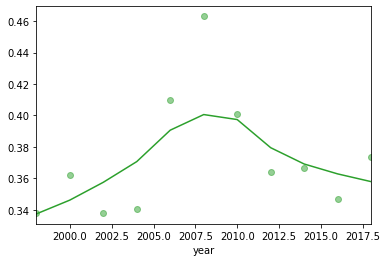

In [296]:
from utils import plot_series_lowess

by_year = valid.groupby('year')['y'].mean()
plot_series_lowess(by_year, 'C2')

And here's what they look like by cohort.

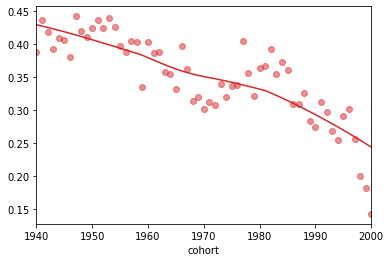

In [297]:
by_cohort = valid.groupby('cohort')['y'].mean()
plot_series_lowess(by_cohort, 'C3')

## Testing the model

Now we can run logistic regression with year and cohort as explanatory variables.

I consider two versions of this model, with and without quadratic terms.  It seems like the model with quadratic terms does a better job of capturing the period and cohort effects.

In [298]:
import statsmodels.formula.api as smf

formula = ('y ~ year + cohort')
model = smf.logit(formula, data=valid).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.656549
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                16692
Model:                          Logit   Df Residuals:                    16689
Method:                           MLE   Df Model:                            2
Date:                Fri, 10 Jan 2020   Pseudo R-squ.:                0.004275
Time:                        09:49:24   Log-Likelihood:                -10959.
converged:                       True   LL-Null:                       -11006.
Covariance Type:            nonrobust   LLR p-value:                 3.663e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8315      5.215      0.543      0.587      -7.390      13.053
year           0.0095      0.003      3.706      0.000       0.004       0.015
cohort        -0.0115      0.001     -9.511      0.000      -0.014      -0.009
==============================================================================
"""

In [299]:
formula = ('y ~ year + y2 + cohort + c2')
model = smf.logit(formula, data=valid).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.655773
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                16692
Model:                          Logit   Df Residuals:                    16687
Method:                           MLE   Df Model:                            4
Date:                Fri, 10 Jan 2020   Pseudo R-squ.:                0.005451
Time:                        09:49:25   Log-Likelihood:                -10946.
converged:                       True   LL-Null:                       -11006.
Covariance Type:            nonrobust   LLR p-value:                 5.376e-25
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.1692      9.292     -3.785      0.000     -53.381     -16.958
year           0.0289      0.005      6.254      0.000       0.020       0.038
y2            -0.0023      0.000     -5.035      0.000      -0.003      -0.001
cohort        -0.0118      0.001     -8.130      0.000      -0.015      -0.009
c2         -3.484e-05   8.19e-05     -0.425      0.671      -0.000       0.000
==============================================================================
"""

In [300]:
formula = ('y ~ year + y2 + cohort + c2 + c3')
model = smf.logit(formula, data=valid).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.655770
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                16692
Model:                          Logit   Df Residuals:                    16686
Method:                           MLE   Df Model:                            5
Date:                Fri, 10 Jan 2020   Pseudo R-squ.:                0.005456
Time:                        09:49:25   Log-Likelihood:                -10946.
converged:                       True   LL-Null:                       -11006.
Covariance Type:            nonrobust   LLR p-value:                 2.990e-24
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.0023      9.919     -3.428      0.001     -53.443     -14.562
year           0.0289      0.005      6.261      0.000       0.020       0.038
y2            -0.0024      0.000     -5.042      0.000      -0.003      -0.001
cohort        -0.0124      0.002     -5.194      0.000      -0.017      -0.008
c2         -1.539e-05      0.000     -0.154      0.878      -0.000       0.000
c3           1.77e-06   5.26e-06      0.336      0.737   -8.55e-06    1.21e-05
==============================================================================
"""

The following plot shows the data grouped by cohort and the model for someone interviewed in 2008.

We can use it to confirm that the model is capturing the cohort effect.

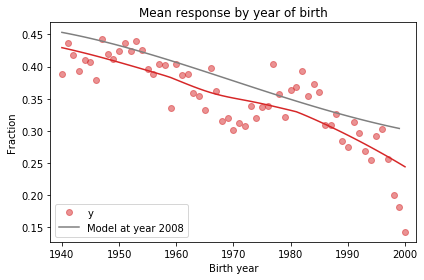

In [301]:
xs = np.arange(1940, 2000)

dfp = pd.DataFrame()
dfp['cohort'] = xs
dfp['year'] = 2008
dfp['y2'] = (dfp['year']-2004)**2
dfp['c2'] = (dfp['cohort']-1970)**2
dfp['c3'] = (dfp['cohort']-1970)**3

plot_series_lowess(by_cohort, 'C3')
ys = model.predict(dfp)
plt.plot(xs, ys, color='C7', label='Model at year 2008')

plt.xlim(1938, 2002)
decorate(xlabel='Birth year',
         ylabel='Fraction',
         title='Mean response by year of birth',
         loc='lower left')

plt.tight_layout()
plt.savefig('generation_by_cohort.png', dpi=150)

The following plot shows the data grouped by year along with predictions for people born in 1968 and 1993.

We can use it to confirm that the model captures the period effect, and we can see the generational difference as measured by the model.

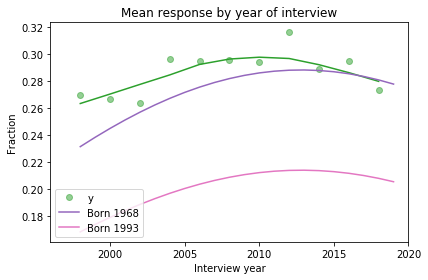

In [262]:
plot_series_lowess(by_year, 'C2')

xs = np.arange(1998, 2020)

dfp = pd.DataFrame()
dfp['year'] = xs
dfp['cohort'] = 1968
dfp['y2'] = (dfp['year']-2004)**2
dfp['c2'] = (dfp['cohort']-1970)**2
dfp['c3'] = (dfp['cohort']-1970)**3

ys = model.predict(dfp)
plt.plot(xs, ys, color='C4', label='Born 1968')

dfp['cohort'] = 1993
ys = model.predict(dfp)
plt.plot(xs, ys, color='C6', label='Born 1993')

decorate(xlabel='Interview year',
         ylabel='Fraction',
         title='Mean response by year of interview',
         loc='lower left')
plt.xlim(1996, 2020)

plt.savefig('generation_by_year', dpi=150)

## Comparing generations

Now let's see how things change from one generation to the next, controlling to period effects.

I'll use the model to generate predictions for two hypothetical members of this group, born in 1968 and 1993, both interviewed in 2018.

Here's a DataFrame that describes these hypothetical people.

In [263]:
df_pred = pd.DataFrame()
df_pred['cohort'] = [1968, 1993]
df_pred['year'] = 2018
df_pred['y2'] = (df_pred['year']-2004)**2
df_pred['c2'] = (df_pred['cohort']-1970)**2
df_pred['c3'] = (df_pred['cohort']-1970)**3
df_pred

,cohort,year,y2,c2,c3
0,1968,2018,196,4,-8
1,1993,2018,196,529,12167


And here are the predictions.

In [264]:
model.predict(df_pred)

0    0.280852
1    0.201243
dtype: float64

## Running the model

The following function encapsulates the steps in the previous section.

In [265]:
def run_model(df, varname, value, formula):
    """Runs the model and generates predictions.
    
    df: DataFrame
    varname: string variable name
    value: value or list of values considered "yes"
    formula: string patsy model
    
    returns: array of predicted values based on df_pred
    """
    value = np.atleast_1d(value)
    valid = df.dropna(subset=[varname]).copy()
    valid['y'] = (valid[varname].isin(value)).astype(int)
    model = smf.logit(formula, data=valid).fit(disp=0)
    res = model.predict(df_pred)
    return res.values

Depending on `formula`, we can run either the linear or quadratic version of the model.

In [266]:
#formula = 'y ~ year + cohort'
#formula = 'y ~ year + y2 + cohort + c2'
formula = 'y ~ year + y2 + cohort + c2 + c3'

Here are the results for Christians and Nones.

In [267]:
run_model(christian, varname, value, formula)

array([0.28085169, 0.20124302])

In [268]:
run_model(none, varname, value, formula)

array([0.03442896, 0.03817344])

## Comparing results

The following function runs the analysis for the two groups and return an array with predictions for 4 hypothetical people:

* Christian born in 1968
* Christian born in 1993
* None born in 1968
* None born in 1993

In [269]:
def compare(df, varname, value):
    christian = df[df['christian']]
    none = df[df['none']]

    c = run_model(christian, varname, value, formula)
    n = run_model(none, varname, value, formula)
    return np.hstack([c, n]) * 100

In [270]:
compare(df, varname, value)

array([28.08516892, 20.12430165,  3.44289599,  3.81734432])

The following function runs the same analysis 101 times, using each of the resampled datasets.

It computes the 5th, 50th, and 95th percentiles in each column and returns an array with one row for each percentile and one column for each of the 4 hypothetical people.

In [271]:
def compare_iter(dfs, varname, value):
    t = [compare(df, varname, value) for df in dfs]
    a = np.array(t)
    percentiles = np.percentile(a, [5, 50, 95], axis=0)
    return percentiles

In [272]:
percentiles = compare_iter(dfs, varname, value)
percentiles

array([[28.65101432, 19.74193596,  2.2695887 ,  2.97257609],
       [30.11273943, 21.91327412,  3.71919116,  3.89548952],
       [31.78215012, 23.81139566,  5.04135907,  5.55335347]])

## Plotting the results

The following functions visualize the results.

In [273]:
def plot_interval(y, interval, dy=0.16, **options):
    """Show a confidence interval.
    
    y: vertical coordinate
    interval: triple of low, med, and high
    dy: height of the error bars
    options: passed to plt
    """
    low, mid, high = interval
    plt.hlines(y+dy, low, high, alpha=0.6, **options)
    plt.vlines([low, high], y+dy, y+dy/2, alpha=0.6, **options)

In [274]:
color_map = {'Christian':'C0',
             'None':'C1'}

def plot_arrow(y, row, group):
    """Plot an arrow showing generational changes.
    
    y: vertical coordinate
    row: x1, x2 pair
    group: string group name
    """
    color = color_map[group]
    label1 = f'{group} born 1968'
    label2 = f'{group} born 1993'
    
    x1, x2 = row    
    dx = x2 - x1
    plt.hlines(y, x1, x2, color=color, alpha=0.3)
    
    plt.plot(x1, y, 'o', color=color, label=label1)
    
    style = '>' if x2 > x1 else '<'
    plt.plot(x2, y, style, color=color, label=label2)

In [275]:
def plot_percentiles(y, percentiles, dy=0.12):
    """Plot the results from the resampled analysis.
    
    y: vertical coordinate
    percentiles: array with a row for each percentile and
                 column for each hypothetical person
    dy: vertical offset for the first group
    """
    plot_interval(y+dy, percentiles[:, 2], color='C1')
    plot_arrow(y+dy, percentiles[1, 2:4], group='None')
    plot_interval(y-dy, percentiles[:, 0], color='C0')
    plot_arrow(y-dy, percentiles[1, 0:2], group='Christian')

In [276]:
def miniplot(percentiles):
    """Make a plot with just one variable"""
    plot_percentiles(0, percentiles)
    plt.ylim(-1.5, 1.5)
    plt.gca().invert_yaxis()

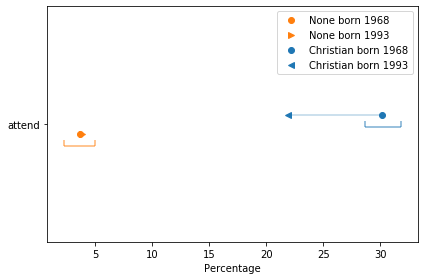

In [277]:
miniplot(percentiles)
plt.legend()

plt.yticks([0], [varname])
decorate(xlabel='Percentage')

## Beliefs and attitudes

Now let's see what the results look like for a variety of beliefs and attitudes.

The following list contains variable names, the response I've selected, and a label that summarizes the selected response.

As an example, here's a complete analysis of a single variable.

pray [1, 2, 3, 4]
[88.64014414 79.02553422 42.42939496 27.36045101]
[[87.36607046 77.5964954  40.73463178 23.39981756]
 [88.60220296 79.5213753  44.20904724 26.65050877]
 [89.62262558 81.53221359 48.17391681 28.93114145]]


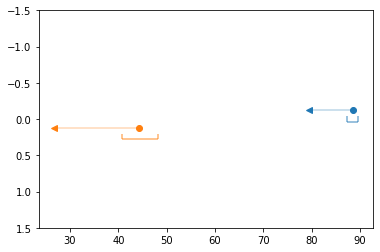

In [278]:
varname = 'pray'
value = value_map[varname]
print(varname, value)

res = compare(df, varname, value)
print(res)
percentiles = compare_iter(dfs, varname, value)
print(percentiles)
miniplot(percentiles)

For testing, we can loop through the variables and run one analysis with the unresampled data.

In [227]:
for varname, value, _ in variables:
    print(varname)
    res = compare(df, varname, value)
    print(res)

spkmil
[73.5113101  76.76801946 82.09560968 78.39559141]
spkmslm
[45.49596897 36.16927047 59.53604459 53.6932326 ]
spkath
[79.22311623 78.04532283 89.69533261 89.5105957 ]
spkcom
[69.46353225 68.75260772 81.12576215 83.42409051]
spkrac
[60.3880369  49.91127651 68.47108633 58.15589464]
spkhomo
[90.06235488 90.4766765  94.4764429  95.82608918]
colmil
[59.49662759 66.43455177 66.02818803 68.87707294]
colmslm
[32.43295797 26.14526947 45.31159224 35.16720515]
colath
[64.03971692 72.31061918 75.72620643 83.06921543]
colcom
[63.78654967 68.70265262 77.15069651 79.11245972]
colrac
[45.40934808 39.49995269 48.12065303 40.06686363]
colhomo
[89.17096349 92.52793162 94.96915779 93.93005577]
libmil
[72.26322264 76.80931845 85.93400702 84.70593488]
libmslm
[48.76353068 40.22516432 64.43893098 56.1513263 ]
libath
[74.79277381 76.19890115 92.86989688 92.6605855 ]
libcom
[71.47928341 74.34902723 85.86445345 86.97307526]
librac
[61.67809039 51.13471775 76.10257378 60.81905199]
libhomo
[81.79362286 88.88

And here's how we run the complete analysis for all variables.

It takes a few minutes.

In [156]:
def generate_results(variables, results=None):
    if results is None:
        results = {}

    for varname, value, _ in variables:
        if varname in results:
            continue
        print(varname)
        percentiles = compare_iter(dfs, varname, value)
        results[varname] = percentiles
        
    return results

In [228]:
# uncomment to clear saved results
# results = None

In [229]:
results = generate_results(variables, results)

sprtprsn
relexp
relactiv
pray
attend


The following function generates a plot for a collection of variable names.

In [159]:
def multiplot(results, varnames, **options):
    """Make a plot showing results for several variables.
    
    results: map from varname to array of percentiles
    varnames: list of string varnames
    loc: string location for the legend.
    """
    plt.figure(figsize=(8, 4.5))
    
    for i, varname in enumerate(varnames):
        percentiles = results[varname]
        plot_percentiles(i, percentiles)

    # label the y axis
    labels = [label_map[varname] for varname in varnames]
    plt.yticks(range(len(varnames)), labels)

    # make a legend with just the first four entries
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    
    loc = options.pop('loc', 'best')
    ax.legend(handles[:4], labels[:4], loc=loc)

    # flip the axes so the results go from top to bottom
    plt.gca().invert_yaxis()
    
    underride(options, xlabel='Percentage', legend=False)
    decorate(**options)
    plt.tight_layout()

## Free speech

There are always some people whose ideas are considered bad or dangerous by other people. 

* For instance, somebody who is against all churches and religion . . .
If such a person wanted to make a speech in your (city/town/community) against churches and religion, should he be allowed to speak, or not?

* Or consider a person who believes that Blacks are genetically inferior...
If such a person wanted to make a speech in your community claiming that Blacks are inferior, should he be allowed to speak, or not?

* Now, I should like to ask you some questions about a man who admits he is a Communist.
Suppose this admitted Communist wanted to make a speech in your community. Should he be allowed to speak, or not?

* Consider a person who advocates doing away with elections and letting the military run the country.
If such a person wanted to make a speech in your community, should he be allowed to speak, or not?

* And what about a man who admits that he is a homosexual?
Suppose this admitted homosexual wanted to make a speech in your community. Should he be allowed to speak, or not?

* Now consider a Muslim clergyman who preaches hatred of the United States.
If such a person wanted to make a speech in your community preaching hatred of the United States, should he be allowed to speak, or not?

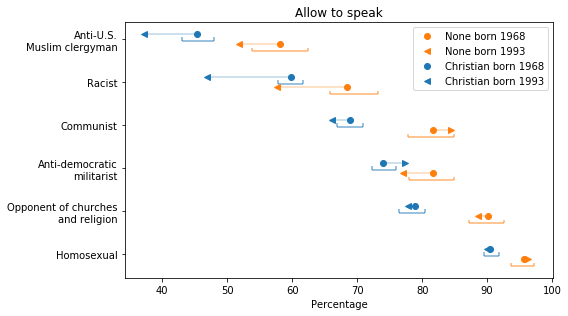

In [160]:
varnames = ['spkmslm', 'spkrac', 'spkcom', 'spkmil', 'spkath', 'spkhomo']
multiplot(results, varnames, title='Allow to speak')

There are always some people whose ideas are considered bad or dangerous by other people. 

* For instance, somebody who is against all churches and religion . . .
Should such a person be allowed to teach in a college or university, or not?

* Now consider a Muslim clergyman who preaches hatred of the United States.
Should such a person be allowed to teach in a college or university, or not?

* Questions associated with this variable:
Or consider a person who believes that Blacks are genetically inferior....
Should such a person be allowed to teach in a college or university, or not?

* Now, I should like to ask you some questions about a man who admits he is a Communist.
Suppose he is teaching in a college. Should he be fired, or not?

* Consider a person who advocates doing away with elections and letting the military run the country.
Should such a person be allowed to teach in a college or university, or not?

* And what about a man who admits that he is a homosexual?
Should such a person be allowed to teach in a college or university, or not?

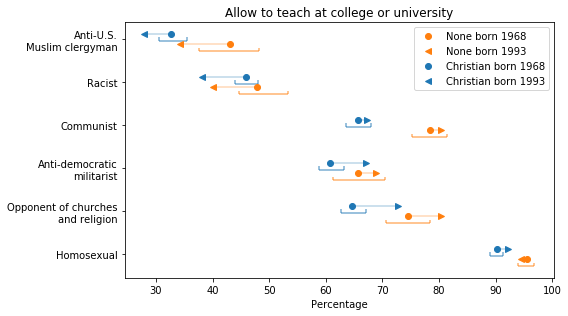

In [161]:
varnames = ['colmslm', 'colrac', 'colcom', 'colmil', 'colath', 'colhomo']
multiplot(results, varnames, title='Allow to teach at college or university');

There are always some people whose ideas are considered bad or dangerous by other people. 

* libath: For instance, somebody who is against all churches and religion . . .
If some people in your community suggested that a book he wrote against churches and religion should be taken out of your public library, would you favor removing this book, or not?

* librac: Or consider a person who believes that Blacks are genetically inferior.
If some people in your community suggested that a book he wrote which said Blacks are inferior should be taken out of your public library, would you favor removing this book, or not?

* libcom: Now, I should like to ask you some questions about a man who admits he is a Communist.
Suppose he wrote a book which is in your public library. Somebody in your community suggests that the book should be removed from the library. Would you favor removing it, or not?

* libmil: Consider a person who advocates doing away with elections and letting the military run the country.
Suppose he wrote a book advocating doing away with elections and letting the military run the country.  Somebody in your community suggests that the book be removed from the public library. Would you favor removing it, or not?

* libhomo: And what about a man who admits that he is a homosexual?
If some people in your community suggested that a book he wrote in favor of homosexuality should be taken out of your public library, would you favor removing this book, or not?

* libmslm: Now consider a Muslim clergyman who preaches hatred of the United States.
If some people in your community suggested that a book he wrote which preaches hatred of the United States should be taken out of your public library, would you favor removing this book, or not?

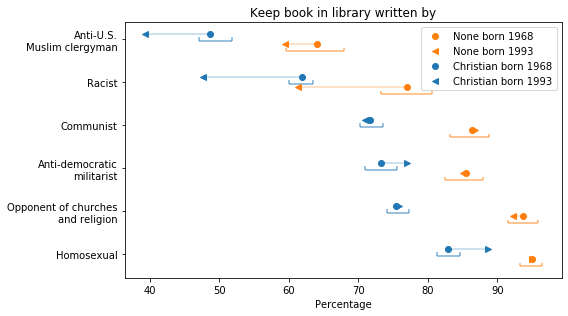

In [162]:
varnames = ['libmslm', 'librac', 'libcom', 'libmil', 'libath', 'libhomo']
multiplot(results, varnames, title='Keep book in library written by');

## Confidence in institutions

"I am going to name some institutions in this country. As far as the people running these institutions are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?"

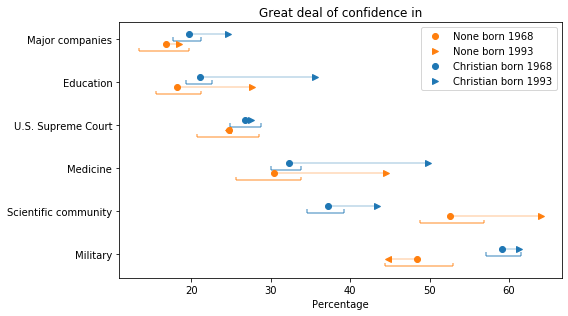

In [163]:
varnames = ['conbus', 'coneduc', 'conjudge', 'conmedic', 'consci', 'conarmy']
multiplot(results, varnames, loc='upper right', title='Great deal of confidence in');

("title='Great", 'deal', 'of', 'confidence', "in');")

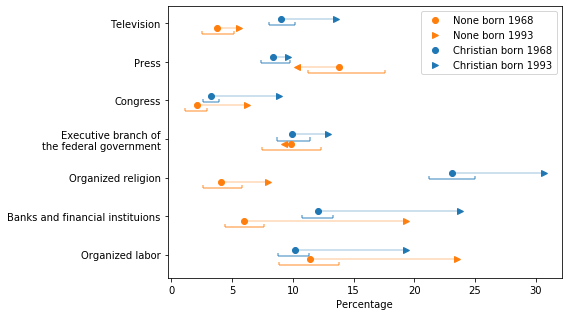

In [164]:
varnames = ['contv', 'conpress', 'conlegis', 'confed', 'conclerg', 'confinan', 'conlabor']
multiplot(results, varnames, loc='upper right', title='Great deal of confidence in');

## Allocation of resources

"We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount."

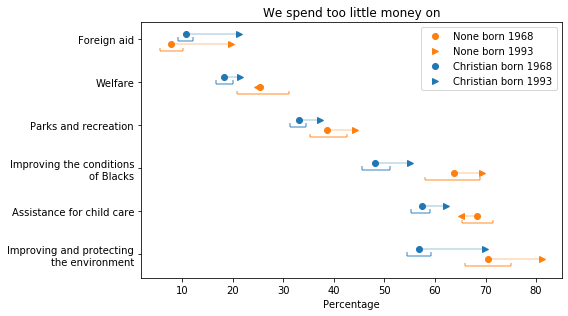

In [289]:
varnames = ['nataid', 'natfare', 'natpark', 'natrace', 'natchld', 'natenvir']
multiplot(results, varnames, title='We spend too little money on')

plt.savefig('generation5.png', dpi=150)

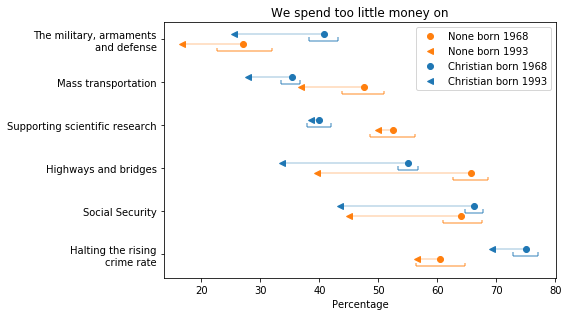

In [290]:
varnames = ['natarms', 'natmass', 'natsci', 'natroad', 'natsoc', 'natcrime']
multiplot(results, varnames, loc='upper right', title='We spend too little money on')

plt.savefig('generation6.png', dpi=150)

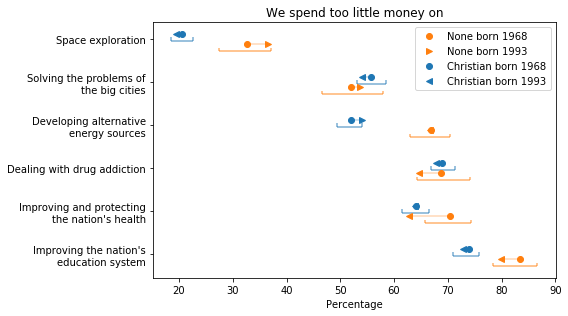

In [302]:
varnames = ['natspac', 'natcity', 'natenrgy', 'natdrug', 'natheal', 'nateduc']
multiplot(results, varnames, loc='upper right', title='We spend too little money on')

plt.savefig('generation7.png', dpi=150)

## Issues related to sex

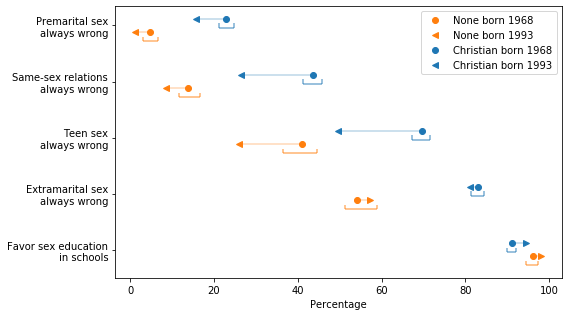

In [304]:
varnames = ['premarsx', 'homosex', 'teensex', 'xmarsex', 'sexeduc']
multiplot(results, varnames, loc='upper right')

plt.savefig('generation8.png', dpi=150)

## Outlook

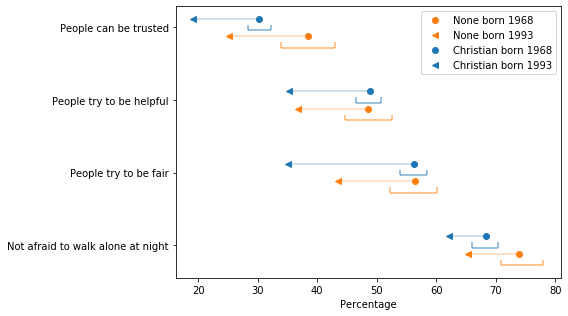

In [169]:
varnames = ['trust', 'helpful', 'fair', 'fear']
multiplot(results, varnames)

## Public policy

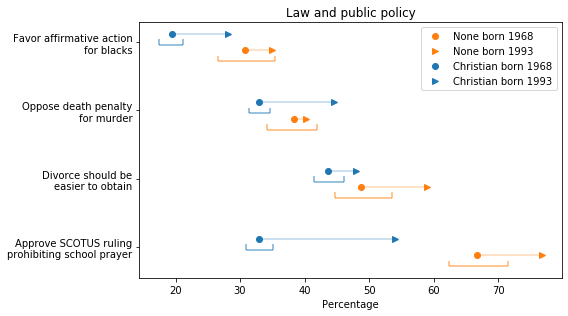

In [170]:
varnames = ['affrmact', 'cappun', 'divlaw', 'prayer']
multiplot(results, varnames, loc='upper right', title='Law and public policy')

plt.savefig('generation3.png', dpi=150)

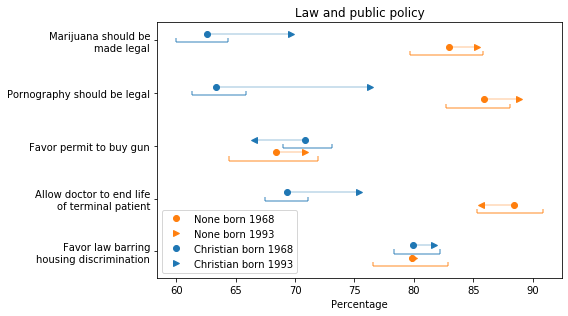

In [171]:
varnames = ['grass', 'pornlaw', 'gunlaw', 'letdie1', 'racopen']
multiplot(results, varnames, title='Law and public policy')

plt.savefig('generation2.png', dpi=150)

## Abortion

"Please tell me whether or not you think it should be possible for a pregnant woman to obtain a legal abortion if ...


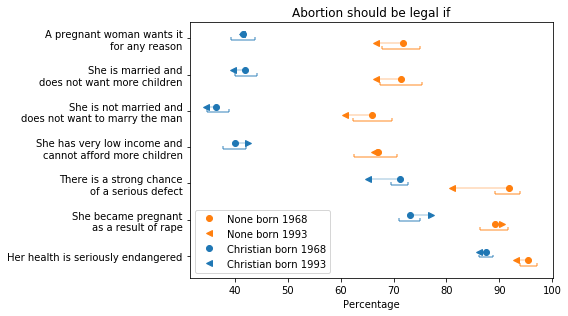

In [172]:
varnames = ['abany', 'abnomore', 'absingle', 'abpoor', 'abdefect', 'abrape', 'abhlth']

multiplot(results, varnames, title='Abortion should be legal if', loc='lower left')

plt.savefig('generation4.png', dpi=150)

## Religion

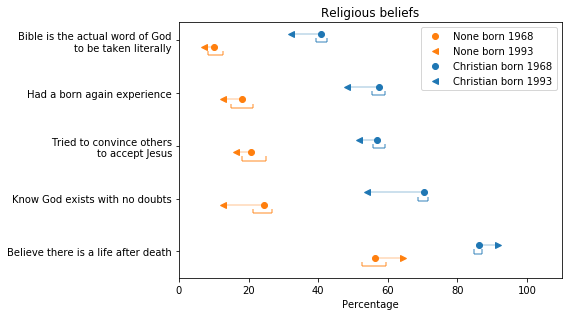

In [82]:
varnames = ['bible', 'reborn', 'savesoul', 'god', 'postlife']
multiplot(results, varnames, 
          loc='upper right', 
          title='Religious beliefs',
          xlim=[0, 110])

plt.savefig('generation1.png', dpi=150)

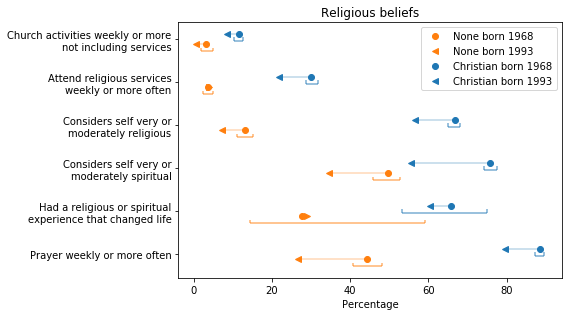

In [303]:
varnames = ['relactiv', 'attend', 'relpersn', 'sprtprsn', 'relexp', 'pray']
multiplot(results, varnames, 
          loc='upper right', 
          title='Religious beliefs',
          #xlim=[0, 110]
         )

plt.savefig('generation1b.png', dpi=150)

## Gender roles and work

"Tell me if you agree or disagree with this statement: Most men are better suited emotionally for politics than are most women."  Select "agree"

    df.fepol.replace([0, 8, 9], np.nan, inplace=True)
    df.fejobaff.replace([0, 8, 9], np.nan, inplace=True)
    df.fehire.replace([0, 8, 9], np.nan, inplace=True)
    df.fechld.replace([0, 8, 9], np.nan, inplace=True)
    df.fepresch.replace([0, 8, 9], np.nan, inplace=True)
    df.fefam.replace([0, 8, 9], np.nan, inplace=True)
    df.discaffm.replace([0, 8, 9], np.nan, inplace=True)
    df.discaffw.replace([0, 8, 9], np.nan, inplace=True)
    df.meovrwrk.replace([0, 8, 9], np.nan, inplace=True)

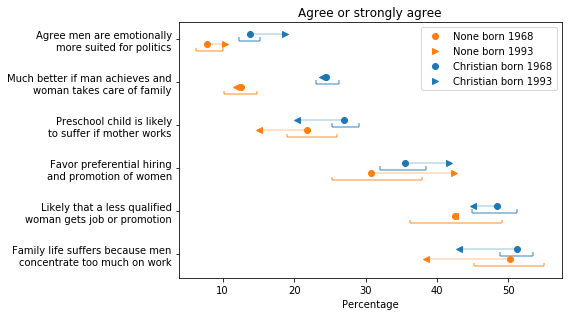

In [184]:
varnames = ['fepol', 'fefam', 'fepresch', 'fejobaff', 'discaffm', 'meovrwrk']
multiplot(results, varnames, title='Agree or strongly agree');

(60, 85)

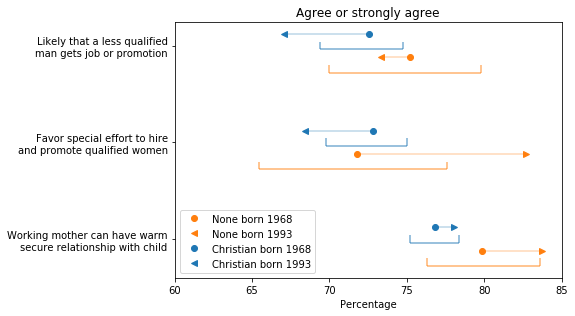

In [188]:
varnames = ['discaffw', 'fehire', 'fechld']
multiplot(results, varnames, title='Agree or strongly agree', loc='lower left')

plt.xlim(60,85);

## Misc

"Do you strongly agree, agree, disagree, or strongly disagree that it is sometimes necessary to discipline a child with a good, hard spanking?"

"Tell me if you agree or disagree with this statement: Most men are better suited emotionally for politics than are most women."  Select "agree"

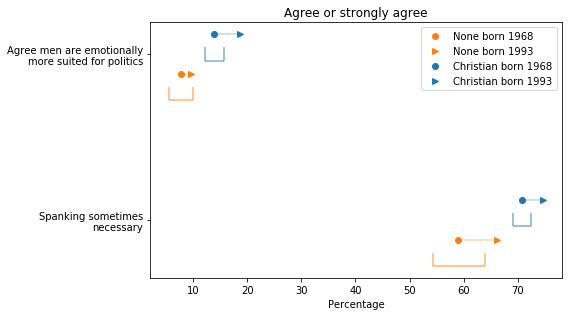

In [83]:
varnames = ['fepol', 'spanking']
multiplot(results, varnames, title='Agree or strongly agree');

In [63]:
t = []
for varname, _, _ in variables:
    if varname.startswith('con'):
        t.append(varname)
t

['confinan',
 'conbus',
 'conclerg',
 'coneduc',
 'confed',
 'conlabor',
 'conpress',
 'conmedic',
 'contv',
 'conjudge',
 'consci',
 'conlegis',
 'conarmy']